In [1]:
import pickle 
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

In [2]:
def ass_info(week_assignments):
    over_ass = 0
    empty = 0
    lawyers = set()
    for ass in week_assignments:
        lawyers.update(ass)
        if len(ass) > 1:
            over_ass += len(ass) - 1
        elif len(ass) == 0:
            empty += 1
    return len(lawyers), over_ass, empty

def get_load(week):
    return sum(map(lambda x: x[0], week))

In [3]:
def get_data(assignments, spr, sr, lawyers_time, sa, weeks):
    greedy_fos = {}
    greedy_pfos = {}
    greedy_ass = {}
    saa_fos = {}
    saa_pfos = {}
    saa_ass = {}
    services = {}
    mode1 = "saa"
    mode2 = "greedy"


    for rate in assignments:
        for lamb in assignments[rate]:
            saa_sr = sr[rate][lamb][mode1]
            saa_fo = {week: sum(ratings) for week, ratings in saa_sr.items()}
            saa_fo = np.cumsum(list(saa_fo.values()))

            greedy_sr = sr[rate][lamb][mode2]
            greedy_fo = {week: sum(ratings) for week, ratings in greedy_sr.items()}
            greedy_fo = np.cumsum(list(greedy_fo.values()))


            saa_spr = spr[rate][lamb][mode1]
            saa_penalized_fo = {week: sum(ratings) for week, ratings in saa_spr.items()}
            saa_penalized_fo = np.cumsum(list(saa_penalized_fo.values()))

            greedy_spr = spr[rate][lamb][mode2]
            greedy_penalized_fo = {week: sum(ratings) for week, ratings in greedy_spr.items()}
            greedy_penalized_fo = np.cumsum(list(greedy_penalized_fo.values()))


            saa_assignment = assignments[rate][lamb][saa]
            greedy_assignment = assignments[rate][lamb][greedy]
            weeks = list(assignments[rate][lamb][mode1].keys())
            info_per_week = np.array([(len(saa_assignment[week]), 
                             get_load(sa[rate][lamb][mode1][week])) for week in weeks])
            greedy_per_week = np.array([ass_info(greedy_assignment[week]) for week in weeks])
            saa_per_week = np.array([ass_info(saa_assignment[week]) for week in weeks])


            greedy_fos[(rate, lamb)] = greedy_fo
            greedy_pfos[(rate, lamb)] = greedy_penalized_fo
            greedy_ass[(rate, lamb)] = greedy_per_week
            saa_fos[(rate, lamb)] = saa_fo
            saa_pfos[(rate, lamb)] = saa_penalized_fo
            saa_ass[(rate, lamb)] = saa_per_week
            services[(rate, lamb)] = info_per_week
    return (greedy_fos, greedy_pfos, greedy_ass), (saa_fos, saa_pfos, saa_ass), services

In [4]:
def create_tables(rate, lambs, weeks, solvers, services, saa_ass, greedy_ass):
    columns = [f"w{week}" for week in weeks]
    index = pd.MultiIndex.from_product([
        solvers,
        ["abogados asignados", "sobreasignaciones", "servicios botados"]
    ])

    index = pd.MultiIndex.from_tuples([("servicios totales", ""), ("tiempo demandado", "")]
                                      + list(index))

    table = pd.DataFrame(columns=columns, index=index)
    table.loc[("servicios totales", "")] = services[rate, lambs[0]][:, 0]
    table.loc[("tiempo demandado", "")] = services[rate, lambs[0]][:, 1]

    for lamb in lambs:
        key1 = f"saa-{lamb}"
        #table.loc[(key1, "rating"), :] = np.round(saa_fos[rate, lamb], 2)
        #table.loc[(key1, "penalized rating"), :] = np.round(saa_pfos[rate, lamb], 2)
        table.loc[(key1, "abogados asignados"), :] = saa_ass[rate, lamb][:, 0]
        table.loc[(key1, "sobreasignaciones"), :] = saa_ass[rate, lamb][:, 1]
        table.loc[(key1, "servicios botados"), :] = saa_ass[rate, lamb][:, 2]

    #table.loc[("greedy", "rating"), :] = np.round(saa_fos[rate, lamb], 2)
    #table.loc[("greedy", "penalized rating"), :] = np.round(greedy_pfos[rate, lamb], 2)
    table.loc[("greedy", "abogados asignados"), :] = greedy_ass[rate, lamb][:, 0]
    table.loc[("greedy", "sobreasignaciones"), :] = greedy_ass[rate, lamb][:, 1]
    table.loc[("greedy", "servicios botados"), :] = greedy_ass[rate, lamb][:, 2]
    table.insert(loc=len(weeks), column="total", value=table.sum(axis=1))

    h = table.iloc[[0, 1], :]   

    t1 = table.iloc[2:, :].loc[(slice(None), "servicios botados"), :].swaplevel(0, 1, axis=0)
    t1 = h.append(t1) 

    t2 = table.iloc[2:, :].loc[(slice(None), "abogados asignados"), :].swaplevel(0, 1, axis=0)
    t2 = h.append(t2)

    t3 = table.iloc[2:, :].loc[(slice(None), "sobreasignaciones"), :].swaplevel(0, 1, axis=0)
    t3 = h.append(t3)
    return table, t1, t2, t3

# 130 percent #

In [12]:
with open('results/assignments.pickle', 'rb') as file:
    assignments = pickle.load(file)
    
with open('results/spr.pickle', 'rb') as file:
    spr = pickle.load(file)

with open('results/sr.pickle', 'rb') as file:
    sr = pickle.load(file)
    
with open('results/time_lawyers.pickle', 'rb') as file:
    lawyers_time = pickle.load(file)
    
with open('results/sa.pickle', 'rb') as file:
    sa = pickle.load(file)
    
mode1, mode2 = 'saa', 'greedy'

In [13]:
rates = list(spr.keys())
lambs = list(spr[4].keys())
saa, greedy = list(spr[4][1].keys())
weeks = list(spr[4][1][saa].keys())

print(rates)
print(lambs)
print(saa, greedy)
print(weeks)

[4]
[1]
saa greedy
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15]


In [14]:
greedy_info, saa_info, services = get_data(assignments, spr, sr, lawyers_time, sa, weeks)
greedy_fos, greedy_pfos, greedy_ass = greedy_info
saa_fos, saa_pfos, saa_ass = saa_info

### rate = 4 ###

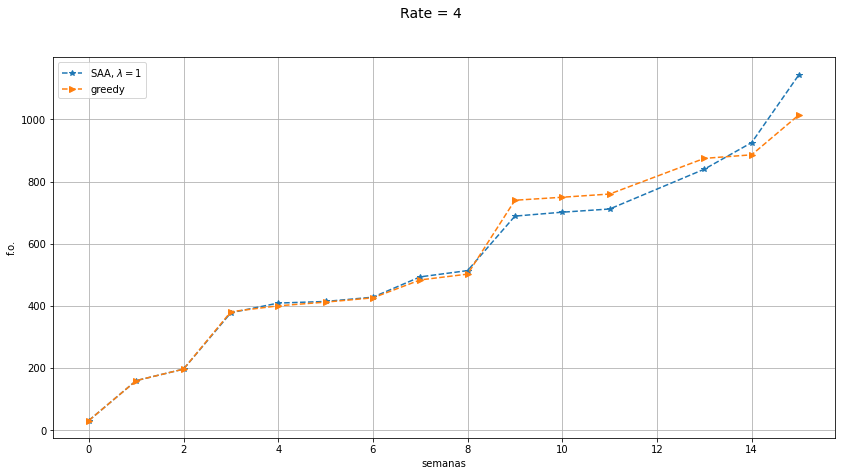

In [15]:
fig, ax1 = plt.subplots(1, 1, figsize=(14, 7))

rate = 4
weeks = list(spr[rate][1]['saa'].keys())


symbols = ["--*", "--o", "--s"]
for i, lamb in enumerate(lambs):
    ax1.plot(weeks, saa_fos[rate, lamb], symbols[i])
    

ax1.plot(weeks, greedy_fos[rate, lamb], "-->") 


ax1.grid()
ax1.legend(list(map(lambda x: "SAA " + r"$\lambda=$" + str(x), lambs)) + ["greedy"])
ax1.legend(list(map(lambda x: "SAA "+  r"$\lambda=$" + str(x), lambs)) + ["greedy"])
ax1.set_xlabel('semanas')
ax1.set_ylabel('f.o.')
ax1.legend(list(map(lambda x: "SAA, " + r"$\lambda=$" + str(x), lambs)) + ["greedy"])
ax1.legend(list(map(lambda x: "SAA, " + r"$\lambda=$" + str(x), lambs)) + ["greedy"])
ax1.set_xlabel('semanas')
ax1.set_ylabel('f.o.')

fig.suptitle(f"Rate = {rate}", fontsize=14)
plt.show()

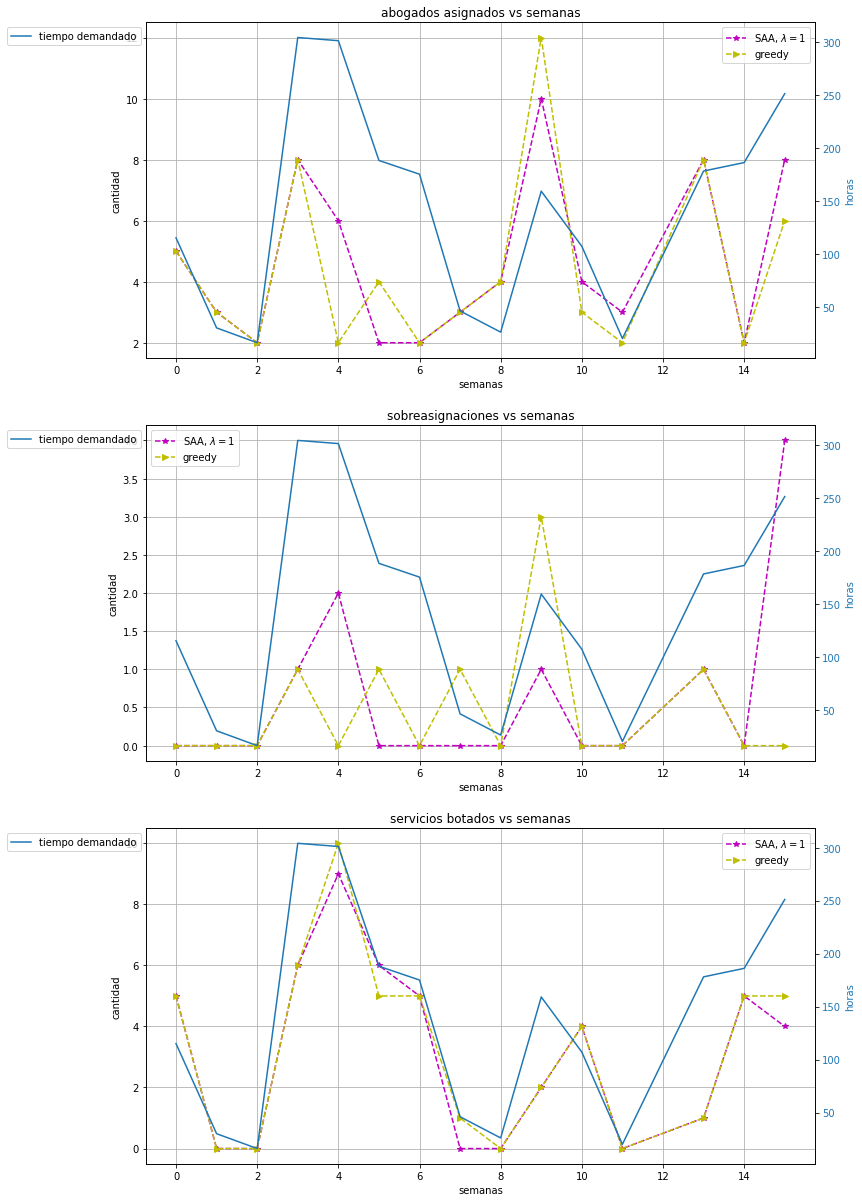

In [17]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 21))

axs = [ax1, ax2, ax3]
twins = [ax1.twinx(), ax2.twinx(), ax3.twinx()]

rate = 4
weeks = list(spr[rate][1]['saa'].keys())


symbols = ["--*", "--o", "--s"]
colors = ["m", "g", "r"]
legend = (list(map(lambda x: "SAA, " + r"$\lambda=$" + str(x), lambs)) + 
            ["greedy", "servicios totales"])
labels = ["abogados asignados", "sobreasignaciones", "servicios botados"]

for j in range(3): # se recorren los 3 dato
    for i, lamb in enumerate(lambs):
        axs[j].plot(weeks, saa_ass[rate, lamb][:, j], symbols[i], color=colors[i])

    axs[j].plot(weeks, greedy_ass[rate, lamb][:, j], "-->", color="y") 
    #axs[j].scatter(weeks, services[rate, lamb][:, 0], marker="o", color="black")
    axs[j].grid()
    axs[j].legend(legend)
    axs[j].set_ylabel('cantidad')
    axs[j].set_xlabel('semanas')
    axs[j].set(title=f"{labels[j]} vs semanas")

    color = 'tab:blue'
    twins[j].set_ylabel('horas', color=color)  # we already handled the x-label with ax1
    twins[j].plot(weeks, services[rate, lamb][:, 1], color=color)
    twins[j].tick_params(axis='y', labelcolor=color)
    twins[j].legend(["tiempo demandado"], bbox_to_anchor=[0, 1])
    
plt.show()

In [33]:
solvers = ["greedy", "saa-0.8"]
table, t1, t2, t3 = create_tables(rate, lambs, weeks, solvers, 
                                  services, saa_ass, greedy_ass)
table = table.drop(("saa-0.8",))
h = table.iloc[[0, 1], :]   

t1 = table.iloc[2:, :].loc[(slice(None), "servicios botados"), :].swaplevel(0, 1, axis=0)
t1 = h.append(t1) 

t2 = table.iloc[2:, :].loc[(slice(None), "abogados asignados"), :].swaplevel(0, 1, axis=0)
t2 = h.append(t2)

t3 = table.iloc[2:, :].loc[(slice(None), "sobreasignaciones"), :].swaplevel(0, 1, axis=0)
t3 = h.append(t3)
table

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: PerformanceWarning: indexing past lexsort depth may impact performance.
  interactivity=interactivity, compiler=compiler, result=result)


w0  w1  w2   w3   w4   w5   w6  w7  w8  \
servicios totales                      10   5   2   15   14    9    7   3   4   
tiempo demandado                      115  30  16  304  301  188  175  46  26   
greedy            abogados asignados    5   3   2    8    2    4    2   3   4   
                  sobreasignaciones     0   0   0    1    0    1    0   1   0   
                  servicios botados     5   0   0    6   10    5    5   1   0   
saa-1             abogados asignados    5   3   2    8    6    2    2   3   4   
                  sobreasignaciones     0   0   0    1    2    0    0   0   0   
                  servicios botados     5   0   0    6    9    6    5   0   0   

                                       w9  w10 w11  w13  w14  w15   total  
servicios totales                      14    9   3   10    7   12   124.0  
tiempo demandado                      159  107  20  178  186  251  2102.0  
greedy            abogados asignados   12    3   2    8    2    6    66.0  
                  sobreasignaciones     3    0   0    1    0    0     7.0  
                  servicios botados     2    4   0    1    5    5    49.0  
saa-1             abogados asignados   10    4   3    8    2    8    70.0  
                  sobreasignaciones     1    0   0    1    0    4     9.0  
                  servicios botados     2    4   0    1    5    4    47.0

w0  w1  w2   w3   w4   w5   w6  w7  w8   w9  w10  \
servicios totales          10   5   2   15   14    9    7   3   4   14    9   
tiempo demandado          115  30  16  304  301  188  175  46  26  159  107   
servicios botados greedy    5   0   0    6   10    5    5   1   0    2    4   
                  saa-1     5   0   0    6    9    6    5   0   0    2    4   

                         w11  w13  w14  w15   total  
servicios totales          3   10    7   12   124.0  
tiempo demandado          20  178  186  251  2102.0  
servicios botados greedy   0    1    5    5    49.0  
                  saa-1    0    1    5    4    47.0

In [30]:
t2

w0  w1  w2   w3   w4   w5   w6  w7  w8   w9  w10  \
servicios totales           10   5   2   15   14    9    7   3   4   14    9   
tiempo demandado           115  30  16  304  301  188  175  46  26  159  107   
abogados asignados greedy    5   3   2    8    2    4    2   3   4   12    3   
                   saa-1     5   3   2    8    6    2    2   3   4   10    4   

                          w11  w13  w14  w15   total  
servicios totales           3   10    7   12   124.0  
tiempo demandado           20  178  186  251  2102.0  
abogados asignados greedy   2    8    2    6    66.0  
                   saa-1    3    8    2    8    70.0

In [32]:
t3

w0  w1  w2   w3   w4   w5   w6  w7  w8   w9  w10  \
servicios totales          10   5   2   15   14    9    7   3   4   14    9   
tiempo demandado          115  30  16  304  301  188  175  46  26  159  107   
sobreasignaciones greedy    0   0   0    1    0    1    0   1   0    3    0   
                  saa-1     0   0   0    1    2    0    0   0   0    1    0   

                         w11  w13  w14  w15   total  
servicios totales          3   10    7   12   124.0  
tiempo demandado          20  178  186  251  2102.0  
sobreasignaciones greedy   0    1    0    0     7.0  
                  saa-1    0    1    0    4     9.0